In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [13]:


# 데이터 불러오기
items = pd.read_csv("./data/items.csv")
shops = pd.read_csv("./data/shops.csv")
train = pd.read_csv("./data/sales_train.csv")
test = pd.read_csv("./data/test.csv")
cats = pd.read_csv('./data/item_categories.csv')


<AxesSubplot:xlabel='item_price'>

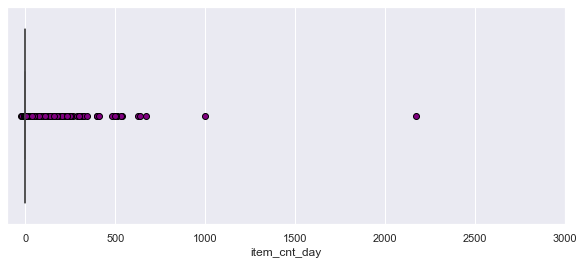

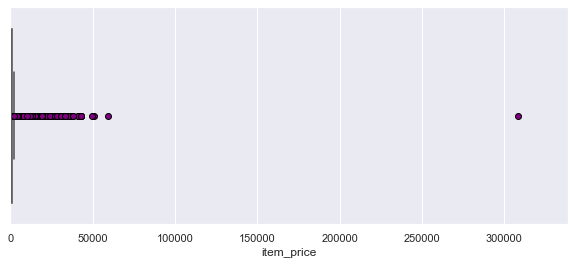

In [14]:

# Data Cleaning
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

In [15]:
# Remove outlier
train = train[(train.item_price < 300000 )& (train.item_cnt_day < 1000)]
# remove negative item price
train = train[train.item_price > 0].reset_index(drop = True)


In [16]:
# Cleaning shops data
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11


In [17]:


# Clean up some shop names and add 'city' and 'category' to shops df.
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

In [18]:


# Only keep shop category if there are 5 or more shops of that category, the rest are grouped as "other".
category = []
for cat in shops.category.unique():
    if len(shops[shops.category == cat]) >= 5:
        category.append(cat)    
shops.category = shops.category.apply( lambda x: x if (x in category) else "other" )


In [19]:

# label encoding
from sklearn.preprocessing import LabelEncoder
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_id", "shop_category", "shop_city"]]

In [20]:

# Cleaning Item Category Data
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "category" ] = "Игры"
category = []
for cat in cats.type_code.unique():
    if len(cats[cats.type_code == cat]) >= 5: 
        category.append( cat )
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "etc")

In [21]:

# Label Encoding
cats.type_code = LabelEncoder().fit_transform(cats.type_code)
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats = cats[["item_category_id", "subtype_code", "type_code"]]


In [22]:

# Cleaning Item Data
import re
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x
  

In [23]:

 # Cleaning Item name
# split item names by first bracket
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

# replace special characters and turn to lower case
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# fill nulls with '0'
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

/var/folders/pq/_bzx9rqx2hs53brb_m6pwqtc0000gn/T/ipykernel_45835/3979867440.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
/var/folders/pq/_bzx9rqx2hs53brb_m6pwqtc0000gn/T/ipykernel_45835/3979867440.py:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  items["name1"], items["name3"] = items.item_name.str.split("(", 1).str
/var/folders/pq/_bzx9rqx2hs53brb_m6pwqtc0000gn/T/ipykernel_45835/3979867440.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
/var/folders/pq/_bzx9rqx2hs53brb_m6pwqtc0000gn/T/ipykernel_45835/3979867440.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lo

In [24]:
# return all characters except the last if name 2 is not "0" - the closing bracket
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

In [25]:

# clean item type
items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42
2,2,40,4,1011
3,3,40,4,1010
4,4,40,4,1572


In [26]:


# Preprocessing create a matrix df with every combination of month, shop and item in order of increasing month. Item_cnt_day is summed into an item_cnt_month.
from itertools import product
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )


In [27]:
# add revenue to train df
train["revenue"] = train["item_cnt_day"] * train["item_price"]
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)


In [28]:

# Create a test set for month 34.
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)


In [29]:

# Concatenate train and test sets.
matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )

In [30]:
# Add shop, items and categories data onto matrix df.
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)

In [31]:
# Feature Engineering, add lag features to matrix df.
# Define a lag feature function
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [32]:
# Add item_cnt_month lag features. 
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )

item_cnt_month


In [33]:

# Add the previous month's average item_cnt.
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)
matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )

date_avg_item_cnt


In [34]:


# Add lag values of item_cnt_month for month / item_id.
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

date_item_avg_item_cnt


In [35]:

# Add lag values for item_cnt_month for every month / shop combination.
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)
matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_avg_item_cnt"] )
matrix.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )


/var/folders/pq/_bzx9rqx2hs53brb_m6pwqtc0000gn/T/ipykernel_45835/1363287629.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)


date_shop_avg_item_cnt


In [36]:
# Add lag values for item_cnt_month for month/shop/item.
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)
matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_item_avg_item_cnt"] )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )


/var/folders/pq/_bzx9rqx2hs53brb_m6pwqtc0000gn/T/ipykernel_45835/1372447736.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)


date_shop_item_avg_item_cnt


In [37]:

# Add lag values for item_cnt_month for month/shop/item subtype.
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix.date_shop_subtype_avg_item_cnt = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_shop_subtype_avg_item_cnt'])
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)


date_shop_subtype_avg_item_cnt


In [38]:
# Add lag values for item_cnt_month for month/city.
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', "shop_city"], how='left')
matrix.date_city_avg_item_cnt = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_city_avg_item_cnt'])
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

date_city_avg_item_cnt


In [39]:
# Add lag values for item_cnt_month for month/city/item.
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix.date_item_city_avg_item_cnt = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_item_city_avg_item_cnt'])
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

date_item_city_avg_item_cnt


In [40]:
# Add average item price on to matix df., add lag values of item price per month
# Add delta price values - how current month average pirce relates to global average.
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)
matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)
group = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)
matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] )

date_item_avg_item_price


In [41]:
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

In [42]:
def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

In [43]:
matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)


In [44]:
# Add total shop revenue per month to matix df. Add lag values of revenue per month.
# Add delta revenue values - how current month revenue relates to global average.
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)

delta_revenue


In [45]:
# Add month and number of days in each month to matrix df.
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

In [46]:
# Add the month of each shop and item first sale.
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')


In [47]:
# Delete first three months from matrix. They don't have lag values.
matrix = matrix[matrix["date_block_num"] > 3]

In [48]:
# Model
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams


In [49]:
data = matrix.copy()
del matrix
gc.collect()
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)
del data
gc.collect();

In [50]:
# Training
model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

rcParams['figure.figsize'] = 12, 4

/opt/homebrew/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.17485	validation_1-rmse:1.11651
[1]	validation_0-rmse:1.12456	validation_1-rmse:1.07827
[2]	validation_0-rmse:1.08155	validation_1-rmse:1.04693
[3]	validation_0-rmse:1.04466	validation_1-rmse:1.02132
[4]	validation_0-rmse:1.01426	validation_1-rmse:1.00230
[5]	validation_0-rmse:0.98731	validation_1-rmse:0.98499
[6]	validation_0-rmse:0.96476	validation_1-rmse:0.97258
[7]	validation_0-rmse:0.94609	validation_1-rmse:0.96109
[8]	validation_0-rmse:0.92730	validation_1-rmse:0.95022
[9]	validation_0-rmse:0.91243	validation_1-rmse:0.94149
[10]	validation_0-rmse:0.89876	validation_1-rmse:0.93319
[11]	validation_0-rmse:0.88795	validation_1-rmse:0.92666
[12]	validation_0-rmse:0.87798	validation_1-rmse:0.92063
[13]	validation_0-rmse:0.86932	validation_1-rmse:0.91628
[14]	validation_0-rmse:0.86083	validation_1-rmse:0.91505
[15]	validation_0-rmse:0.85391	validation_1-rmse:0.91206
[16]	validation_0-rmse:0.84801	validation_1-rmse:0.90914
[17]	validation_0-rmse:0.84224	validation

In [54]:
# Testing
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

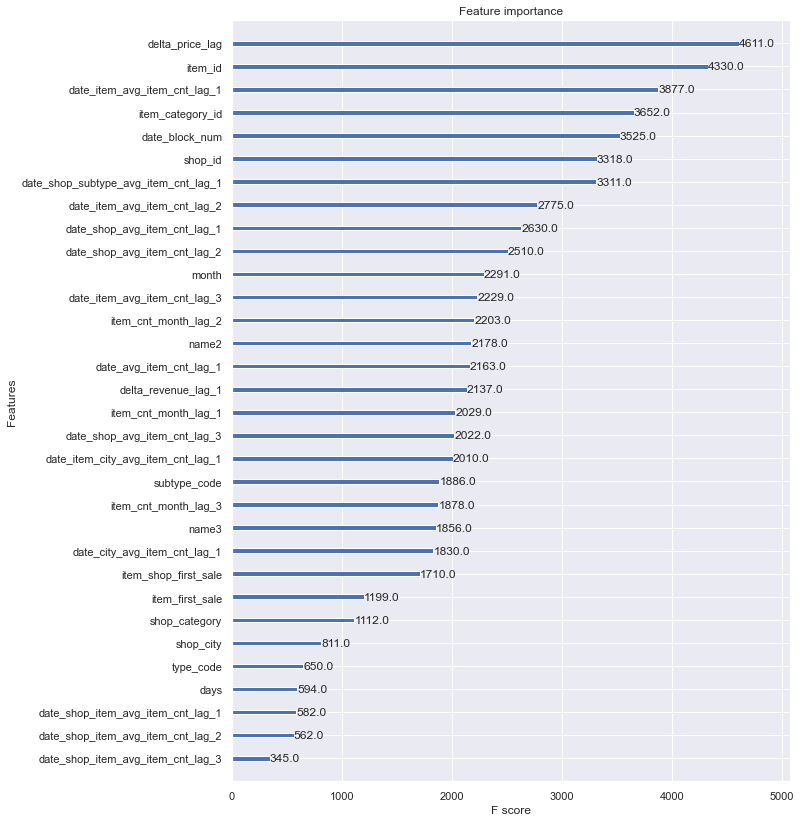

In [53]:
# Plot feature importance
from xgboost import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model, (10,14))